In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [2]:
cd Documents/DATA

C:\Users\Admin\Documents\DATA


In [3]:
bookings = pd.read_csv('data/bookings.csv')
bookings.head()

,booking_id,customer_id,booking_status,booking_create_timestamp,booking_approved_at,booking_checkin_customer_date
0,c54678b7cc49136f2d6af7e481f51cbd,51297304e76186b10a928d9ef432eb62,completed,2007-10-05 10:39:33,2007-10-05 10:50:15,2007-10-13 21:08:13
1,c7dce0b6741e215027345153cdb2fc8b,7a6c6d20dea0b8c802d7efb0830fb474,completed,2008-07-26 20:24:37,2008-07-28 03:07:27,2008-08-09 15:10:45
2,d0c44946d9cf07ec65d47770eb9100c2,bf3443c3d931a36708941ce2a54c0b03,completed,2008-08-10 08:21:49,2008-08-10 08:38:23,2008-08-19 17:49:29
3,e918fe9c16f97b45f8a949d5b44dbf5d,20adcdbec7375364d82f88197465ea79,completed,2007-11-21 19:11:06,2007-11-21 19:28:59,2007-12-05 00:11:42
4,e6cb83a9ceb5573f8159ad21c59c0840,ea8866dbdbc4fb7aad2c8ab97904e6da,completed,2008-02-16 21:01:39,2008-02-16 22:03:29,2008-02-19 18:00:02


In [4]:
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/sample_submission_5.csv')

In [5]:
bookings_train_data = pd.merge( train_data,bookings, on='booking_id')
bookings_test_data = pd.merge(test_data,bookings,on='booking_id')


In [6]:
bookings_test_data.drop(['rating_score'],axis=1,inplace=True)

In [7]:
bookings_data = pd.read_csv('data/bookings_data.csv')
customer_data = pd.read_csv('data/customer_data.csv')
hotels_data = pd.read_csv('data/hotels_data.csv')
payments_data = pd.read_csv('data/payments_data.csv')

In [8]:
bookings_data['seller_freq'] = bookings_data.groupby('seller_agent_id')['seller_agent_id'].transform('count')
bookings_data['hotel_freq'] = bookings_data.groupby('hotel_id')['hotel_id'].transform('count')
customer_data['customer_freq'] = customer_data.groupby('customer_unique_id')['customer_unique_id'].transform('count')

In [9]:
hotels_data.dropna(inplace=True)
from sklearn.preprocessing import StandardScaler
x = hotels_data.iloc[:, 1:].values
y = hotels_data.loc[:,['hotel_id']].values
x = StandardScaler().fit_transform(x)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['hotels_info1','hotel_info2'])
hotels_data = pd.concat([hotels_data['hotel_id'],principalDf.abs()], axis = 1)
hotels_data.dropna(inplace=True)

In [11]:
bookings_hotel_data = pd.merge(bookings_data, hotels_data, on= 'hotel_id')

bookings_customer_data = pd.merge(bookings_train_data, customer_data, on='customer_id')
bookings_customer_data_t = pd.merge(bookings_test_data, customer_data, on='customer_id')

total_booking_data = pd.merge(bookings_customer_data,bookings_data, on = 'booking_id',how='left')
total_booking_data_t = pd.merge(bookings_customer_data_t,bookings_data, on = 'booking_id',how='left')

total_booking_data = pd.merge(total_booking_data, hotels_data,on = 'hotel_id',how='left')
total_booking_data_t = pd.merge(total_booking_data_t, hotels_data,on = 'hotel_id',how='left')

total_booking_data = pd.merge(total_booking_data, payments_data,on = 'booking_id',how='left')
total_booking_data = total_booking_data.drop_duplicates(['booking_id'])

total_booking_data_t = pd.merge(total_booking_data_t, payments_data,on = 'booking_id',how='left')
total_booking_data_t = total_booking_data_t.drop_duplicates(['booking_id'])

In [12]:
train_data = total_booking_data.drop(['customer_id', 'customer_unique_id','hotel_id','seller_agent_id','booking_sequence_id'], axis=1) 

subm_data = total_booking_data_t.drop(['customer_id', 'customer_unique_id','hotel_id','seller_agent_id','booking_sequence_id'], axis=1) 


In [13]:
train_data.isnull().sum()         

train_data.dropna(inplace=True)     

subm_data = subm_data.fillna(0)

In [14]:
train_data['booking_create_timestamp'] = pd.to_datetime(train_data['booking_create_timestamp']) 
train_data['booking_approved_at'] = pd.to_datetime(train_data['booking_approved_at'])
train_data['booking_checkin_customer_date'] = pd.to_datetime(train_data['booking_checkin_customer_date'])
train_data['booking_expiry_date'] = pd.to_datetime(train_data['booking_expiry_date'])

train_data['tot_approve_min_diff'] = (train_data.booking_approved_at -train_data.booking_create_timestamp) / pd.Timedelta(minutes=1)
train_data['tot_checkin_min_diff'] = (train_data.booking_checkin_customer_date- train_data.booking_create_timestamp) / pd.Timedelta(minutes=1)
train_data['tot_expiry_min_diff'] = (train_data.booking_expiry_date- train_data.booking_create_timestamp) / pd.Timedelta(hours=1)
train_data.drop(['booking_create_timestamp','booking_approved_at','booking_checkin_customer_date','booking_expiry_date'],axis=1,inplace=True)

subm_data['booking_create_timestamp'] = pd.to_datetime(subm_data['booking_create_timestamp']) 
subm_data['booking_approved_at'] = pd.to_datetime(subm_data['booking_approved_at'])
subm_data['booking_checkin_customer_date'] = pd.to_datetime(subm_data['booking_checkin_customer_date'])
subm_data['booking_expiry_date'] = pd.to_datetime(subm_data['booking_expiry_date'])


subm_data['tot_approve_min_diff'] = (subm_data.booking_approved_at -subm_data.booking_create_timestamp) / pd.Timedelta(minutes=1)
subm_data['tot_checkin_min_diff'] = (subm_data.booking_checkin_customer_date-subm_data.booking_create_timestamp) / pd.Timedelta(minutes=1)
subm_data['tot_expiry_min_diff'] = (subm_data.booking_expiry_date-subm_data.booking_create_timestamp) / pd.Timedelta(hours=1)
subm_data.drop(['booking_create_timestamp','booking_approved_at','booking_checkin_customer_date','booking_expiry_date'],axis=1)

,booking_id,booking_status,country,customer_freq,price,agent_fees,seller_freq,hotel_freq,hotels_info1,hotel_info2,payment_sequential,payment_type,payment_installments,payment_value,tot_approve_min_diff,tot_checkin_min_diff,tot_expiry_min_diff
0,796b98fdf73dbeba33a548910a1c6147,completed,Japan,1,79.79,8.30,130.0,26.0,0.324793,0.700410,1.0,credit_card,1.0,88.09,23.333333,1.361202e+04,87744.672222
1,b201a9f2ecdecbb34bed034bf9e4b658,completed,Portugal,1,149.00,45.12,770.0,343.0,0.426050,0.639931,1.0,credit_card,1.0,194.12,37.316667,1.917243e+04,87720.864722
2,97b385a9be170737859d3511b658677c,completed,Spain,1,179.99,42.85,770.0,118.0,1.575075,1.514361,1.0,credit_card,1.0,222.84,14.100000,1.532737e+04,87696.518333
3,366873cd26c5724d1dcb18dcdf73be66,completed,Spain,1,99.90,13.20,1551.0,3.0,0.251263,1.829989,1.0,credit_card,1.0,462.70,4191.683333,8.338983e+03,87766.144722
7,c3a2e87348811bcfdf22be48aa0d2dce,completed,Cambodia,1,46.90,11.85,631.0,1.0,0.157881,0.024212,1.0,credit_card,2.0,58.75,11.516667,2.143863e+04,88080.475278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58304,b221f926ba560907d8f7f62f01ec64c6,unavailable,Japan,1,0.00,0.00,0.0,0.0,0.000000,0.000000,1.0,credit_card,2.0,327.19,9.633333,-1.952908e+07,-325484.646944
58305,2977fc6ce3d412c60000bdcdda88e6b0,completed,Vietnam,1,118.90,18.93,77.0,2.0,0.060327,0.094811,1.0,credit_card,1.0,137.83,29.316667,9.148883e+03,87648.771944
58306,2269711bd1eaf7eed8fd32a7c95d5cb1,completed,Cambodia,1,29.99,12.79,270.0,25.0,0.623729,0.119129,1.0,credit_card,4.0,42.78,1477.350000,5.772333e+03,87696.802500
58307,245723df7cb52772a34416b41b1acd45,completed,Japan,1,79.60,15.41,429.0,28.0,1.446317,1.129364,1.0,credit_card,2.0,95.01,25.883333,2.574393e+04,87744.714722


In [15]:
train_data['price_diff']= train_data['payment_value'] - train_data['price']

subm_data['price_diff']= subm_data['payment_value'] - subm_data['price']

train_data['price'].replace(to_replace = 0, value = 1, inplace=True)
train_data['relative_change']= train_data['price_diff'] / train_data['price']
train_data.drop(['price','agent_fees','payment_value'],axis=1,inplace=True)

subm_data['price'].replace(to_replace = 0, value = 1, inplace=True)
subm_data['relative_change']= subm_data['price_diff'] / subm_data['price']
subm_data.drop(['price','agent_fees','payment_value'],axis=1,inplace=True)


In [16]:
train_data['country'].replace(['Portugal','USA','Russia','Slovakia','Spain','Vietnam','UK','Japan','Cambodia'],[0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)

train_data['payment_type'].replace(['credit_card','debit_card','gift_card','voucher','not_defined'],[1, 2, 3, 4, 5], inplace=True)

train_data['booking_status'].replace(['completed','canceled'],[0, 1], inplace=True)
train_data.loc[train_data['booking_status'].isin(['unavailable','processing']) ,'booking_status'] = 2
train_data.loc[train_data['booking_status'].isin([ 'processed', 'invoiced', 'approved','created']) ,'booking_status'] = 0

subm_data['country'].replace(['Portugal','USA','Russia','Slovakia','Spain','Vietnam','UK','Japan','Cambodia'],[0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)

subm_data['payment_type'].replace(['0','credit_card','debit_card','gift_card','voucher','not_defined'],[0, 1, 2, 3, 4, 5], inplace=True)


subm_data['booking_status'].replace(['completed','canceled'],[0, 1], inplace=True)
subm_data.loc[subm_data['booking_status'].isin(['unavailable','processing']) ,'booking_status'] = 2
subm_data.loc[subm_data['booking_status'].isin([ 'processed', 'invoiced', 'approved','created']) ,'booking_status'] = 0


<AxesSubplot:>

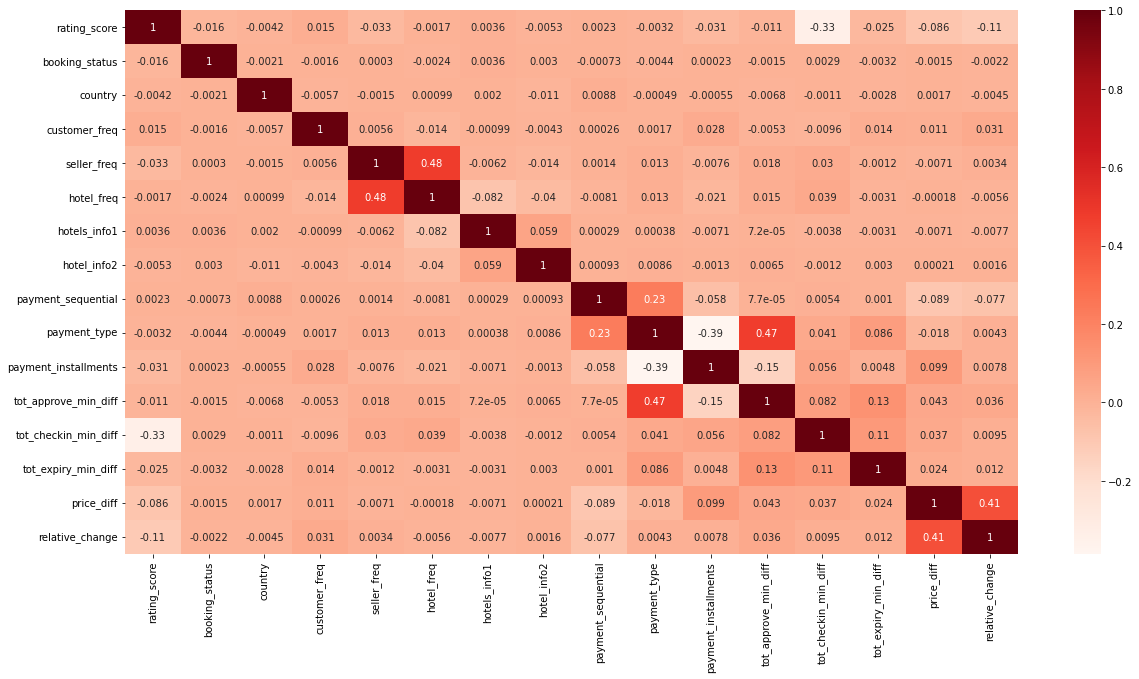

In [17]:
pearson_corr = train_data.corr()
plt.figure(figsize = (20,10))
sb.heatmap(data = pearson_corr, cmap = "Reds", annot = True)


In [18]:
t1_x = subm_data['booking_id']
subm_data.drop(["booking_id",'hotel_freq','customer_freq'],axis=1,inplace=True)


y = train_data["rating_score"]
x1 = train_data['booking_id']
x = train_data.drop(["booking_id","rating_score",'hotel_freq','customer_freq'],axis = 1)


In [19]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)

GradientBoostingRegressor:
Train Root Mean squared error: 1.1498990651707361
Test Root Mean squared error: 1.1510588076048258


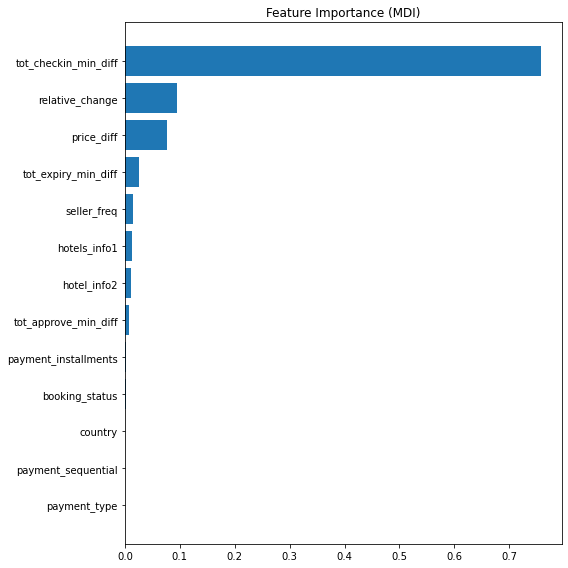

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
reg1 = GradientBoostingRegressor()
reg1.fit(x_train,y_train)
y_pred_train=reg1.predict(x_train)
y_pred = reg1.predict(x_test)
print("GradientBoostingRegressor:")
print("Train Root Mean squared error:",mse(y_train, y_pred_train,squared=False))
print("Test Root Mean squared error:",mse(y_test, y_pred,squared=False))


from sklearn.inspection import permutation_importance
feature_importance = reg1.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(reg1, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()